In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

In [3]:
dataset = pd.read_csv("IMDB Dataset.csv")
train_dataset, test_dataset = dataset[:40000], dataset[40000:]

In [4]:
X_train, y_train = train_dataset["review"].to_numpy(), train_dataset["sentiment"].to_numpy()
X_test, y_test = test_dataset["review"].to_numpy(), test_dataset["sentiment"].to_numpy()

In [5]:
max_len = 256  # Maximum sequence length
embedding_dim = 64  # Dimension of word embeddings
attention_units = 16  # Attention units for self-attention mechanism
num_classes = 2  # Number of output classes (e.g., positive and negative)

In [6]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, attention_units):
        super(SelfAttention, self).__init__()
        self.attention_units = attention_units

    def build(self, input_shape):
        self.WQ = self.add_weight(shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WK = self.add_weight(shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WV = self.add_weight(shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform',
                                  trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.WQ)
        K = tf.matmul(inputs, self.WK)
        V = tf.matmul(inputs, self.WV)

        d_k = tf.cast(tf.shape(K)[-1], tf.float32)
        attention_weights = tf.nn.softmax(tf.matmul(Q, K, transpose_b=True)/tf.math.sqrt(d_k), axis=-1)
        output = tf.matmul(attention_weights, V)

        return output, attention_weights

In [7]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, vocab_size, max_len, embedding_dim, attention_units, num_classes):
        super(SentimentClassifier, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)
        self.positional_encoding = self.positional_encoding(max_len, embedding_dim)
        self.attention = SelfAttention(attention_units)
        self.global_avg_pool = GlobalAveragePooling1D()
        self.dense1 = Dense(256, activation="relu")
        self.dropout = Dropout(0.25)
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.embedding(inputs)
        x *= tf.math.sqrt(tf.cast(tf.shape(x)[-1], tf.float32))
        x += self.positional_encoding[:, :tf.shape(x)[1], :]
        output, attention_weights = self.attention(x)
        output = self.global_avg_pool(output)
        output = self.dense1(output)
        output = self.dropout(output)
        output = self.dense2(output)

        return output, attention_weights

    def positional_encoding(self, position, d_model):
        angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        angle_rads = np.arange(position)[:, np.newaxis] * angle_rates

        # Apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_dataset["review"])
vocab_size = len(tokenizer.word_index) + 1

In [9]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_train_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokenized, padding='post', maxlen=max_len)

In [10]:
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_tokenized = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized, padding='post', maxlen=max_len)

In [11]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_encoded = y_train_encoded.astype(np.int64)
y_test_encoded = y_test_encoded.astype(np.int64)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train_encoded)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_tokenized, y_test_encoded)).batch(32)

In [13]:
classifier = SentimentClassifier(vocab_size, max_len, embedding_dim, attention_units, num_classes)

In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [15]:
epochs = 4
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits, _ = classifier(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)

        grads = tape.gradient(loss_value, classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        if step % 100 == 0:
            print(f"Step {step}/{len(X_train)//64} - Loss: {loss_value.numpy():.4f}")


Epoch 1/4
Step 0/625 - Loss: 0.6955
Step 100/625 - Loss: 0.6884
Step 200/625 - Loss: 0.5527
Step 300/625 - Loss: 0.5187
Step 400/625 - Loss: 0.3627
Step 500/625 - Loss: 0.3192
Step 600/625 - Loss: 0.3254
Epoch 2/4
Step 0/625 - Loss: 0.2675
Step 100/625 - Loss: 0.3448
Step 200/625 - Loss: 0.3319
Step 300/625 - Loss: 0.3534
Step 400/625 - Loss: 0.1855
Step 500/625 - Loss: 0.2451
Step 600/625 - Loss: 0.2019
Epoch 3/4
Step 0/625 - Loss: 0.1416
Step 100/625 - Loss: 0.1572
Step 200/625 - Loss: 0.2467
Step 300/625 - Loss: 0.1695
Step 400/625 - Loss: 0.1020
Step 500/625 - Loss: 0.1541
Step 600/625 - Loss: 0.1134
Epoch 4/4
Step 0/625 - Loss: 0.0722
Step 100/625 - Loss: 0.0447
Step 200/625 - Loss: 0.1006
Step 300/625 - Loss: 0.0640
Step 400/625 - Loss: 0.0251
Step 500/625 - Loss: 0.1011
Step 600/625 - Loss: 0.0229


In [16]:
def visualize_attention_weights(model, inputs, idx, tokenizer):
    _, attention_weights = model(inputs)
    attention_weights = tf.squeeze(attention_weights, axis=0).numpy()

    words = tokenizer.sequences_to_texts(inputs.numpy())[0].split()  # Convert input sequences back to words
    print(words)
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.heatmap(attention_weights[:len(words), :len(words)], cmap='hot', ax=ax, xticklabels=words, yticklabels=words)
    ax.set_title(f"Attention Weights (Sample {idx})")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

['i', 'hope', 'this', 'group', 'of', 'film', 'makers', 'never', 're', 'unites']


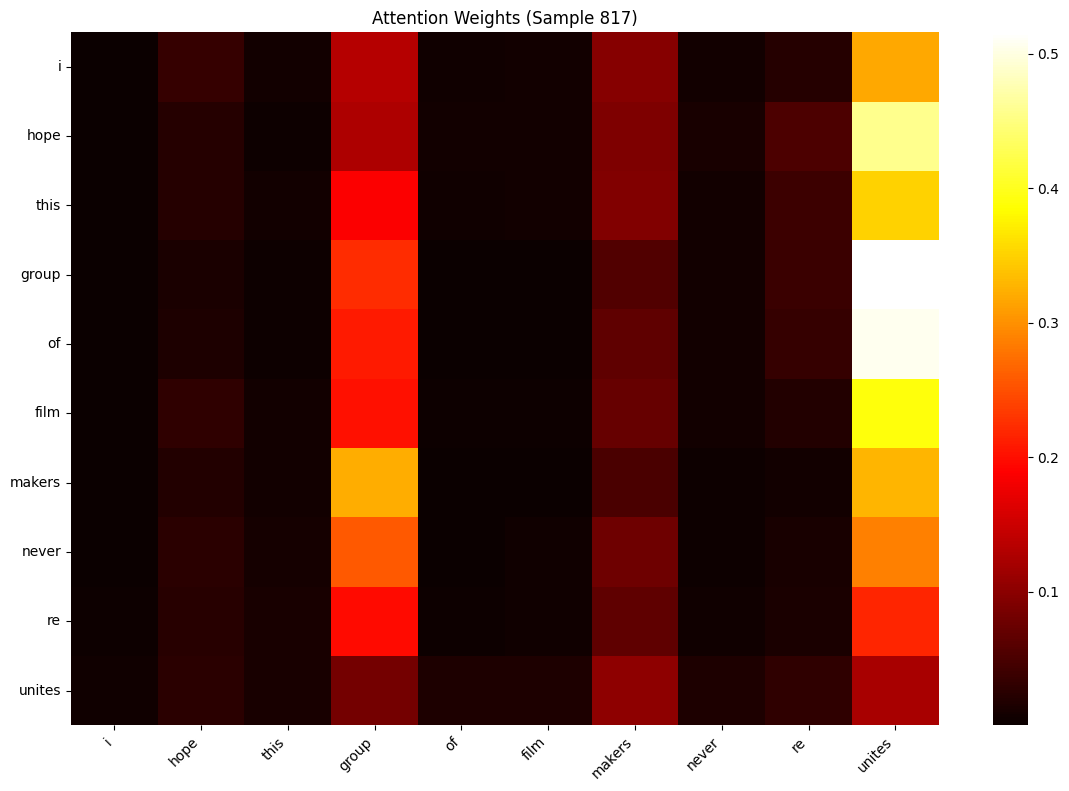

In [17]:
# Visualize attention weights for a sample
sample_index = 817
sample_input = tf.expand_dims(X_test_tokenized[sample_index], axis=0)
visualize_attention_weights(classifier, sample_input, sample_index, tokenizer)

In [18]:
def measure_accuracy(model, dataset):
    correct_predictions = 0
    total_predictions = 0

    for x_batch, y_batch in dataset:
        logits, _ = model(x_batch)
        predicted_labels = tf.argmax(logits, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(tf.equal(predicted_labels, y_batch), dtype=tf.int32))
        total_predictions += x_batch.shape[0]

    accuracy = correct_predictions / total_predictions

    return accuracy

In [19]:
print(f"Training accuracy: {measure_accuracy(classifier, train_dataset).numpy()}")
print(f"Test accuracy: {measure_accuracy(classifier, test_dataset).numpy()}")

Training accuracy: 0.994975
Test accuracy: 0.8837
